### Knowing the probability distiburion of the demand of products can help determine the optimal order quantity.

The Newsvendor problem is a situation where there is uncertain demand for a perishable product.

Newspaper is an example. A newsvendor does not know how many newspapers they will sell that day, and they have to estimate the order quanity. If the amount the newsvendor ordered is too little and the demand is too large, then they lose potential income. If the demand is too little and they ordered too much newspaper, then they will not get a profit on the money they spent to buy the papers.

This problem can be optimized if we know the distribution of the demand *D*, *Co* or the costs of ordering one more newspaper over the demand (*d+1*), and *Cu* the cost of ordering one less newspaper under the demand (*d-1*).

Suppose the CDF of the demand distribution is *F(.)* and *y* is the order quantity. 

The optinal *y = F^-1 (Cu / (Cu + Co))*

We do not always know how the demand is distributed.

**But how can be estimate the distribution?**

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

import os
for dirname, _, filenames in os.walk('D:\library\Github\Innovative-practice\library\csv\第二学期'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\library\Github\Innovative-practice\library\csv\第二学期\test.csv
D:\library\Github\Innovative-practice\library\csv\第二学期\train.csv


## Import Sales/Damand Data and Clean

The factor quantity represents demand of the products.

In [6]:
train_df = pd.read_csv("D:/library/Github/Innovative-practice/library/csv/第二学期/train.csv")
# train[6479:6490]
train  = train_df.drop(train_df.index[6480:]) # after row 6479, all the values are Nan.

In [7]:
train.tail()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
6475,6475.0,31/12/17,Athens,37.96245,23.68708,665871.0,shop_3,orange-power,plastic,1.5lt,1.02,33201.0
6476,6476.0,31/12/17,Larisa,39.63689,22.41761,144302.0,shop_5,orange-power,can,330ml,0.47,46971.0
6477,6477.0,31/12/17,Patra,38.24444,21.73444,168501.0,shop_6,adult-cola,glass,500ml,1.02,47708.0
6478,6478.0,31/12/17,Thessaloniki,40.64361,22.93086,353001.0,shop_4,gazoza,plastic,1.5lt,1.34,27115.0
6479,6479.0,31/12/17,Thessaloniki,40.64361,22.93086,353001.0,shop_4,adult-cola,glass,500ml,1.16,30413.0


In [10]:
test = pd.read_csv("D:/library/Github/Innovative-practice/library/csv/第二学期/test.csv")
test.tail()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
1075,7555,31/12/18,Athens,37.97945,23.71622,664046,shop_1,kinder-cola,plastic,1.5lt,2.52,13760
1076,7556,31/12/18,Athens,37.97945,23.71622,664046,shop_1,orange-power,plastic,1.5lt,2.18,16309
1077,7557,31/12/18,Patra,38.24444,21.73444,168034,shop_6,kinder-cola,can,330ml,0.85,24378
1078,7558,31/12/18,Thessaloniki,40.64361,22.93086,354290,shop_4,adult-cola,plastic,1.5lt,2.17,20691
1079,7559,31/12/18,Irakleion,35.32787,25.14341,137154,shop_2,adult-cola,glass,500ml,1.26,24615


In [11]:
train['date'] = pd.to_datetime(train['date']) # change date to datetime data type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6480 entries, 0 to 6479
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         6480 non-null   float64       
 1   date       6480 non-null   datetime64[ns]
 2   city       6480 non-null   object        
 3   lat        6429 non-null   float64       
 4   long       6434 non-null   float64       
 5   pop        6480 non-null   float64       
 6   shop       6480 non-null   object        
 7   brand      6480 non-null   object        
 8   container  6464 non-null   object        
 9   capacity   6465 non-null   object        
 10  price      6480 non-null   float64       
 11  quantity   6480 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 607.6+ KB


In [12]:
train.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0.0,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1,1.0,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2,2.0,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3,3.0,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4,4.0,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,0.39,25696.0


In [13]:
pd.DataFrame(train.groupby('city').count()['id'])
# Here we see that these are cities in Greece.

,id
city,
Athens,2160
Irakleion,1080
Larisa,1080
Patra,1080
Thessaloniki,1080


In [14]:
pd.DataFrame(train.groupby('brand').count()['id'])
# Since there are multiple brands, we will just focus on the demand 

,id
brand,
adult-cola,1296
gazoza,1296
kinder-cola,1296
lemon-boost,1296
orange-power,1296


#### Let us consider the demand of only one product, Gazoza. Why did I choose that? Because Gazoza is a fun name.

In [15]:
gazoza = train[train['brand'] == 'gazoza'].reset_index(drop=True)

In [16]:
gazoza.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,7.0,2012-01-31,Athens,37.97945,23.71622,672130.0,shop_1,gazoza,glass,500ml,0.49,44734.0
1,17.0,2012-01-31,Irakleion,35.32787,25.14341,134219.0,shop_2,gazoza,glass,500ml,0.58,41378.0
2,18.0,2012-01-31,Irakleion,35.32787,25.14341,134219.0,shop_2,gazoza,plastic,1.5lt,1.00,30757.0
3,19.0,2012-01-31,Irakleion,35.32787,25.14341,134219.0,shop_2,gazoza,can,330ml,0.26,49688.0
4,31.0,2012-01-31,Patra,38.24444,21.73444,164250.0,shop_6,gazoza,glass,500ml,0.57,56428.0


In [17]:
# q = gazoza.groupby(['date'], as_index=False).sum()
# sns.lineplot(x =q['date'], y=q['quantity'])

In [18]:
gazoza.describe()

,id,lat,long,pop,price,quantity
count,1296.000000,1285.000000,1292.000000,1296.000000,1296.000000,1296.000000
mean,3241.861883,38.302604,23.272999,355141.416667,0.668272,44251.839506
std,1871.579618,1.652516,1.087566,232900.701416,0.334543,21232.120037
min,7.000000,35.327870,21.734440,134219.000000,0.110000,7113.000000
25%,1624.000000,37.962450,22.417610,141439.750000,0.370000,28923.000000
50%,3242.500000,37.979450,23.687080,257501.500000,0.620000,40851.500000
75%,4857.000000,39.636890,23.716220,665871.000000,0.880000,54523.750000
max,6478.000000,40.643610,25.143410,672130.000000,1.620000,145287.000000


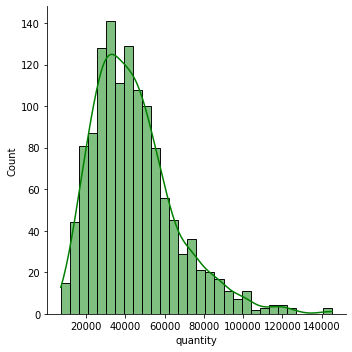

In [19]:
# let's see how the demand of this product is distributed
sns.displot(gazoza['quantity'], kde = True, color = 'g')

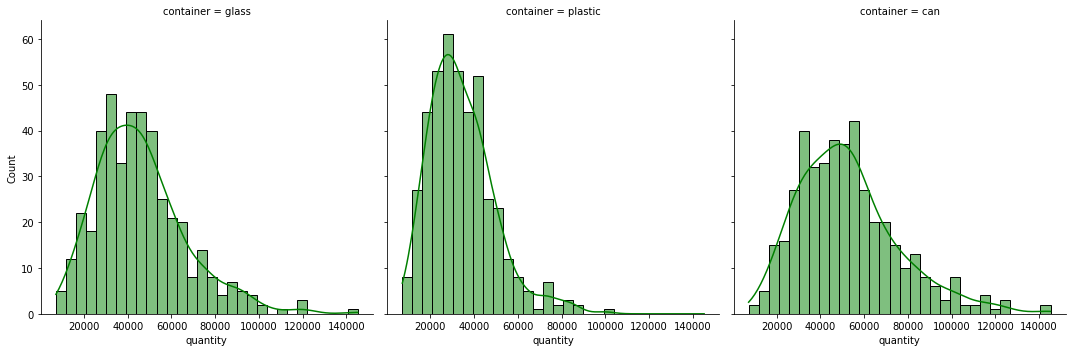

In [20]:
sns.displot(data = gazoza, x = 'quantity', kde = True, col = 'container', color = 'g')

### Now let us try to fit a normal distribution to the demand of Gazoza in Greece
To do this, we find the sample average of the demand to approximate the mean.
We also find the sample standard deviation to approximate the true standard deviation.

In [21]:
# find the sample mean and sample standard deviation
mean = np.mean(gazoza['quantity'])
std = np.std(gazoza['quantity'])


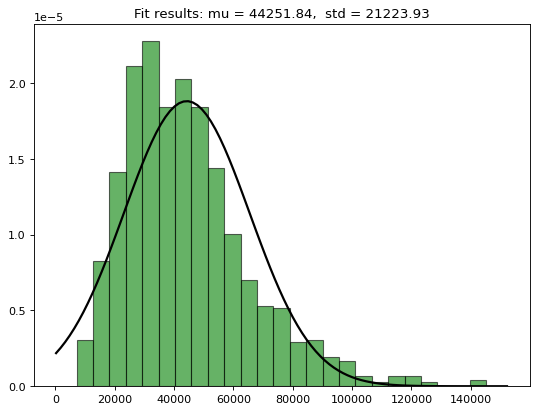

In [22]:
# Plot the histogram.
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(x = gazoza['quantity'], 
         density=True, alpha = 0.6, 
         color='g', bins = 25, linewidth=1, edgecolor='black')


# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)

plt.show()

(The distribution is not really normal. We'll deal with that in a bit.)

Now that we have fit a normal disribution to the demand data, we can calculate the optimal order quanity.

In [23]:
def orderQuan(mean, std, Cu, Co):
    # let y be the optimal order quanity
    criticalVal = Cu/(Cu+Co) # Critical Value for the optimal order quantity
    y = norm.ppf(criticalVal, mean, std) # Calculation for optimal order quanity
    return y

Now let's assume that the cost of underage Cu (!not under-age!) is 0.30 euros and the cost of underage Cu (not under-age) is 0.4 euros.

The optimal order quantity can be calculated as follows.

In [24]:
orderQuan(mean, std, 0.3, 0.4)

40431.27010133479

However, the histogram is skewed. This suggests that the true distribution of the demand is not a normal distribution. Hence we have to find other ways to estimate the distribution of the demand. Afterall, we need the distribution to solve for the optimal order quantity.

## Parametric Probability Density Distribution Estimation

Here, we can find the average and standard deviation of the sample data and use them to estimate the true distribution.

Let's assume that we know the true distribution of the demand to be a normal with mean of 1000 and standard deviation of 200.

How can we use different techniques to approximate the distribution of the demand?

Let us generate a sample data of size 1000 from a distribution of our choice.

(array([  1.,   0.,   1.,   1.,   3.,   4.,   6.,  26.,  38.,  58.,  79.,
        107., 127., 124., 111., 109.,  87.,  45.,  36.,  19.,  10.,   4.,
          3.,   0.,   1.]),
 array([ 142.18796721,  206.44418847,  270.70040973,  334.95663098,
         399.21285224,  463.4690735 ,  527.72529476,  591.98151602,
         656.23773727,  720.49395853,  784.75017979,  849.00640105,
         913.2626223 ,  977.51884356, 1041.77506482, 1106.03128608,
        1170.28750734, 1234.54372859, 1298.79994985, 1363.05617111,
        1427.31239237, 1491.56861362, 1555.82483488, 1620.08105614,
        1684.3372774 , 1748.59349866]),
 <BarContainer object of 25 artists>)

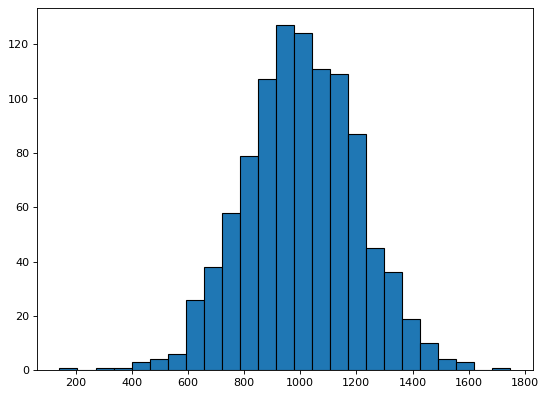

In [25]:
mu, sigma = 1000, 200
sample = np.random.normal(mu, sigma, size=1000)
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(sample, bins = 25, edgecolor='black')

In [26]:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
print('Mean = %.3f,  Standard Deviation = %.3f' % (sample_mean, sample_std))

Mean = 1004.130,  Standard Deviation = 201.815


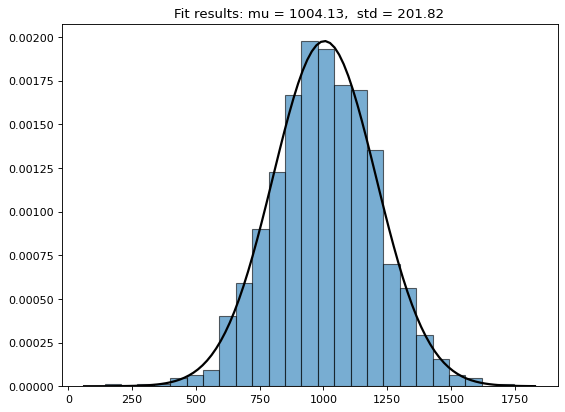

In [27]:
# Plot the Histogram
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(sample, bins = 25, edgecolor='black', alpha = 0.6, density = True) 

# Plot the PDF.
xmin2, xmax2 = plt.xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, sample_mean, sample_std)
plt.plot(x2, p2, 'k', linewidth=2)
title2 = "Fit results: mu = %.2f,  std = %.2f" % (sample_mean, sample_std)
plt.title(title2)

plt.show()

We could have also gotten the same result by utilizing the ``stats.norm.fit()`` function. More on that later.

In [29]:
# for Cu = 190 and Co = 274
orderQuan(sample_mean, sample_std, Cu=190, Co=274)

957.9393057753906

This is a straightforward process when the distribution is normal. 

When the distribution is not normal, it may not be as easy to compute the parameters of the distribution. But we can have the computer do the computation.

### In the following code, we will try to fit multiple distribution to find the distribution with the smallest sse.

The ``stats.<distribution>.fit()`` function reutrns the MLEs for shape, location, and scale parameters from data. MLE stands for Maximum Likelihood Estimate.  Starting estimates for the fit are given by input arguments.

For the normal distribution, the same results could have been achieved by using ``stats.norm.fit()``. We can do this for multiple distibution and see which one fits the best.


[I also wanna point out there a risk of data snooping with this method here.]

In [30]:
%matplotlib inline
import warnings
import matplotlib
import scipy.stats as st
import statsmodels as sm

In [31]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.beta,st.betaprime,st.chi,st.chi2,st.cosine,st.dgamma,st.dweibull,st.erlang,
        st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.genlogistic,st.genpareto,st.gennorm,
        st.genexpon,st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.laplace,st.logistic,st.loggamma,st.loglaplace,
        st.lognorm,st.lomax,st.maxwell,st.nakagami,st.norm,st.pareto,st.pearson3,st.powerlaw,
        st.powerlognorm,st.reciprocal,st.triang,st.tukeylambda,st.uniform,st.weibull_min,st.weibull_max
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)


In [32]:
# Load data from statsmodels datasets
data = pd.Series(gazoza['quantity'])

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200)
print("The best Distibution is: " + best_fit_name)
print("The parameters are: ")
print(best_fit_params)
best_dist = getattr(st, best_fit_name)

The best Distibution is: johnsonsu
The parameters are: 
(-8.186206927332776, 2.5423824268487243, -8010.390617202695, 3873.8009064737016)


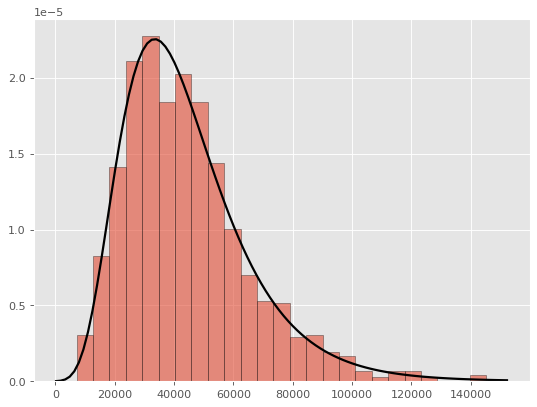

In [33]:
# Plot the Histogram
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(data, bins = 25, edgecolor='black', alpha = 0.6, density = True) 

# Plot the PDF.
xmin5, xmax5 = plt.xlim()
x5 = np.linspace(xmin5, xmax5, 100)
paramSample = st.johnsonsu.fit(data)
p5 = st.johnsonsu.pdf(x5, paramSample[0], paramSample[1], paramSample[2], paramSample[3])
plt.plot(x5, p5, 'k', linewidth=2)
title5 = ""
plt.title(title5)

plt.show()

**Now that we know the parameters of the distrubution, we can easily compute the order quanity using the Newsvendor model formula**

In [27]:
Cu=0.3
Co=0.4
criticalVal = Cu/(Cu+Co) # Critical Value for the optimal order quantity
st.johnsonsu.ppf(criticalVal, paramSample[0], paramSample[1], paramSample[2], paramSample[3]) 
# Calculation for optimal order quanity

37065.11656389761

For the same values of Cu and Co, using the normal distribution, we got an order quantity of 40431.270, which is 3366.1535 more than what we got using the JohnsonSu distribution.

#### Let's see how the distribution fits for the demand from the test set (Demand for 2018).

In [28]:
gazozaTest = test[test['brand'] == 'gazoza'].reset_index(drop=True)

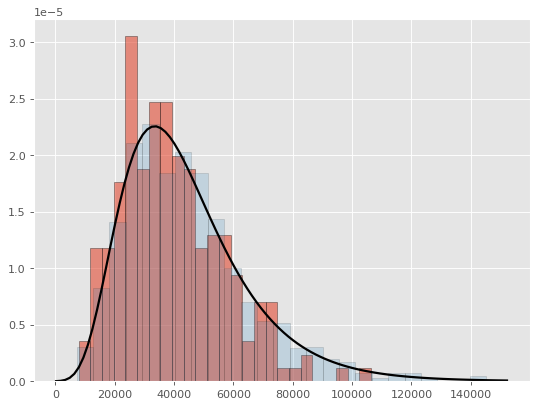

In [29]:
# Plot the Histogram
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(gazozaTest['quantity'], bins = 25, edgecolor='black', alpha = 0.6, density = True) 
plt.hist(data, bins = 25, edgecolor='black', alpha = 0.2, density = True) 

# Plot the PDF.
xmin6, xmax6 = plt.xlim()
x6 = np.linspace(xmin6, xmax6, 100)
paramSample = st.johnsonsu.fit(data)
p6 = st.johnsonsu.pdf(x6, paramSample[0], paramSample[1], paramSample[2], paramSample[3])
plt.plot(x6, p6, 'k', linewidth=2)
title6 = ""
plt.title(title6)

plt.show()

#### And let's see how it fits for other years.

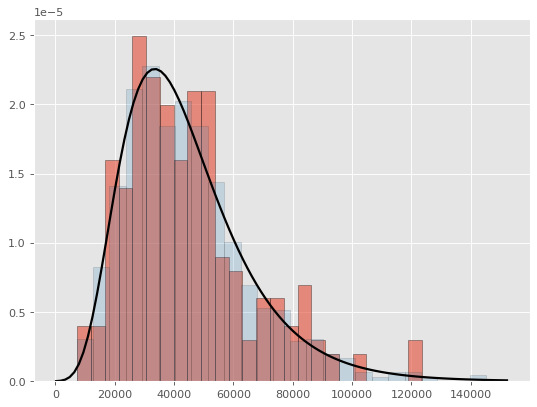

In [30]:
# Plot the Histogram
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(gazoza[pd.DatetimeIndex(gazoza['date']).year ==2014]['quantity'], 
         bins = 25, edgecolor='black', alpha = 0.6, density = True) 
plt.hist(data, bins = 25, edgecolor='black', alpha = 0.2, density = True) 

# Plot the PDF.
xmin6, xmax6 = plt.xlim()
x6 = np.linspace(xmin6, xmax6, 100)
paramSample = st.johnsonsu.fit(data)
p6 = st.johnsonsu.pdf(x6, paramSample[0], paramSample[1], paramSample[2], paramSample[3])
plt.plot(x6, p6, 'k', linewidth=2)
title6 = ""
plt.title(title6)

plt.show()

In [31]:
def sse_johnsonsu(sse_data,train_data, bins =200):
    y, x = np.histogram(sse_data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    # Ignore warnings from data that can't be fit
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        # fit dist to data
        params = st.johnsonsu.fit(train_data)
        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        # Calculate fitted PDF and error with fit in distribution
        pdf = st.johnsonsu.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))
    return sse

print("SSE for train data is: %.9f" % (sse_johnsonsu(data, data)))
print("SSE for test data is: %.9f" % (sse_johnsonsu(gazozaTest['quantity'], data)))
print("SSE for 2014 data is: %.9f" % (sse_johnsonsu(gazoza[pd.DatetimeIndex(gazoza['date']).year ==2014]['quantity'], data)))
print("SSE for 2015 data is: %.9f" % (sse_johnsonsu(gazoza[pd.DatetimeIndex(gazoza['date']).year ==2015]['quantity'], data)))
print("SSE for 2016 data is: %.9f" % (sse_johnsonsu(gazoza[pd.DatetimeIndex(gazoza['date']).year ==2014]['quantity'], data)))
print("SSE for 2017 data is: %.9f" % (sse_johnsonsu(gazoza[pd.DatetimeIndex(gazoza['date']).year ==2015]['quantity'], data)))

SSE for train data is: 0.000000001
SSE for test data is: 0.000000016
SSE for 2014 data is: 0.000000012
SSE for 2015 data is: 0.000000020
SSE for 2016 data is: 0.000000012
SSE for 2017 data is: 0.000000020


## Non-Parametric Density Estimation
1. Using Kernel Density Estimation

read more: https://machinelearningmastery.com/probability-density-estimation/

In [32]:
from sklearn.neighbors import KernelDensity

In [33]:
# the library espects the data to be 2D, so let's reshape it
sampleArray = sample.reshape((len(sample), 1))

In [34]:
# we can try multiple bandwidth values and kernels. Let's start with bandwidth=2, kernel='gaussian'
model = KernelDensity(bandwidth=50, kernel='gaussian')
# I kept inccreasing the bandwidth, 
# but it is important to note that using a low bandwidth can result in overfitting.

model.fit(sampleArray)

KernelDensity(bandwidth=50)

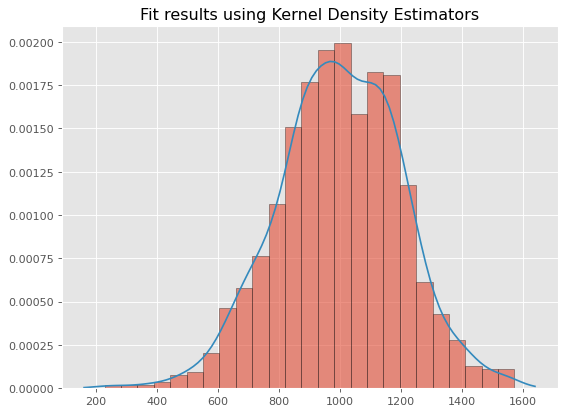

In [35]:
# Plot the Histogram
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(sampleArray, bins = 25, edgecolor='black', alpha = 0.6, density = True) 

# Plot the PDF.
# values = np.asarray([value for value in range(200, 1600)])
# values = values.reshape((len(values), 1))
xmin3, xmax3 = plt.xlim()
x3 = np.linspace(xmin3, xmax3, 100)
x3 = x3.reshape((len(x3), 1))
pKernel = model.score_samples(x3)
pKernel = np.exp(pKernel)
title3 = "Fit results using Kernel Density Estimators"
plt.plot(x3[:], pKernel)
plt.title(title3)

plt.show()

In [36]:
model.get_params(deep=True)

{'algorithm': 'auto',
 'atol': 0,
 'bandwidth': 50,
 'breadth_first': True,
 'kernel': 'gaussian',
 'leaf_size': 40,
 'metric': 'euclidean',
 'metric_params': None,
 'rtol': 0}

Now we can generate a sample from the Kenerl density model that we have gotten.

In [37]:
kernel_sample = model.sample(n_samples=1000, random_state=None)

(array([  2.,   2.,   1.,   3.,   1.,   5.,   6.,  20.,  40.,  45.,  52.,
         86., 107., 115.,  94., 114.,  91.,  81.,  53.,  29.,  25.,  12.,
          9.,   5.,   2.]),
 array([ 187.07534328,  244.94805504,  302.82076681,  360.69347858,
         418.56619035,  476.43890211,  534.31161388,  592.18432565,
         650.05703742,  707.92974918,  765.80246095,  823.67517272,
         881.54788449,  939.42059625,  997.29330802, 1055.16601979,
        1113.03873156, 1170.91144332, 1228.78415509, 1286.65686686,
        1344.52957863, 1402.40229039, 1460.27500216, 1518.14771393,
        1576.0204257 , 1633.89313746]),
 <BarContainer object of 25 artists>)

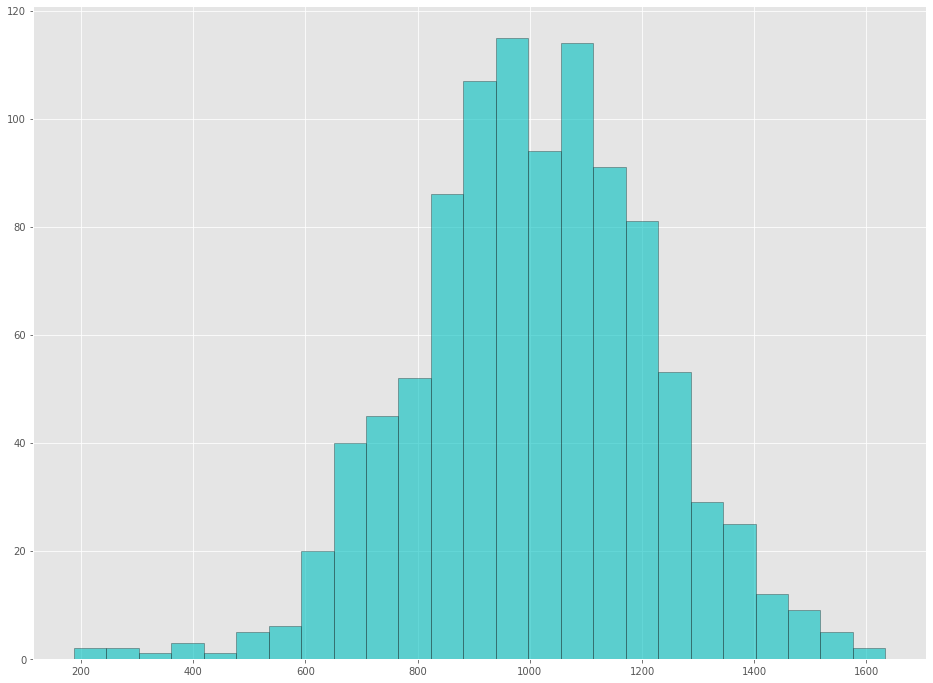

In [38]:
plt.hist(kernel_sample, bins = 25, edgecolor='black', alpha = 0.6, density = False, color = 'c') 

In [39]:
print('Kernel Sample Means = %.2f, and Standard Deviation = %.2f'% (np.mean(kernel_sample), np.std(kernel_sample)))

Kernel Sample Means = 1006.43, and Standard Deviation = 209.04


We can see that the non-parametric method also yielded a good estimate of the true mean and true standard deviation.

Let's apply this non-parametric approach to the gazoza demand data.

In [40]:
model2 = KernelDensity(bandwidth=1000, kernel='gaussian')

gazozaArray = gazoza.loc[:,'quantity'].values
gazozaArray = gazozaArray.reshape((len(gazozaArray),1))

model2.fit(gazozaArray)

KernelDensity(bandwidth=1000)

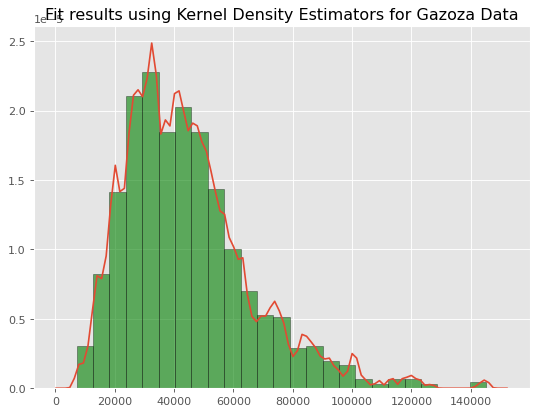

In [41]:
# Plot the Histogram
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(gazozaArray, bins = 25, edgecolor='black', alpha = 0.6, density = True, color = 'g') 

# Plot the PDF.
# values = np.asarray([value for value in range(200, 1600)])
# values = values.reshape((len(values), 1))
xmin4, xmax4 = plt.xlim()
x4 = np.linspace(xmin4, xmax4, 100)
x4 = x4.reshape((len(x4), 1))
pGazoza = model2.score_samples(x4)
pGazoza = np.exp(pGazoza)
title4 = "Fit results using Kernel Density Estimators for Gazoza Data"
plt.plot(x4[:], pGazoza)
plt.title(title4)

plt.show()

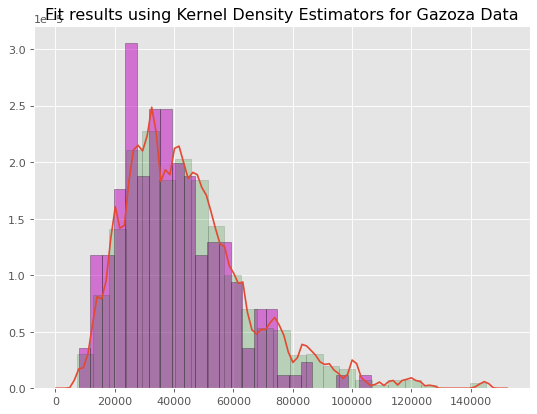

In [42]:
# Plot the Histogram
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(gazozaTest['quantity'], bins = 25, edgecolor='black', alpha = 0.5, density = True, color = 'm') 
plt.hist(gazozaArray, bins = 25, edgecolor='black', alpha = 0.2, density = True, color = 'g') 

# Plot the PDF.
# values = np.asarray([value for value in range(200, 1600)])
# values = values.reshape((len(values), 1))
xmin4, xmax4 = plt.xlim()
x4 = np.linspace(xmin4, xmax4, 100)
x4 = x4.reshape((len(x4), 1))
pGazoza = model2.score_samples(x4)
pGazoza = np.exp(pGazoza)
title4 = "Fit results using Kernel Density Estimators for Gazoza Data"
plt.plot(x4[:], pGazoza)
plt.title(title4)

plt.show()

#### But, how can be use this non-parametric approach in the Newsvendor model?

- The critical value Cu/Cu+Co is equvalent to the area under the curve (AUC) of a probability desnity function to the left of the optimal order quanity. Thus, once we know the critical calue, we can find which order quantity gives an AUC of that value.

In [43]:
qty = pd.DataFrame(gazoza.groupby(['date'], axis =0, as_index=True).sum()['quantity'])

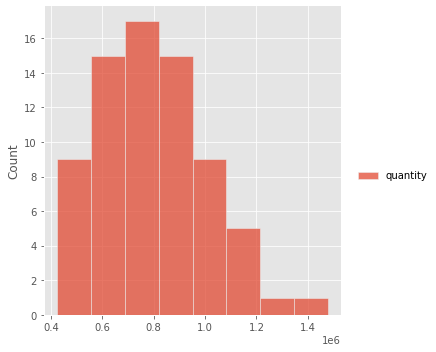

In [44]:
sns.displot(qty, bins=8)

In [45]:
# Find best fit distribution
qty_fit_name, qty_fit_params = best_fit_distribution(qty, 200)
print("The best Distibution is: " + qty_fit_name)
print("The parameters are: ")
print(qty_fit_params)
qty_dist = getattr(st, qty_fit_name)

The best Distibution is: norm
The parameters are: 
(796533.1111111111, 208580.42266324168)


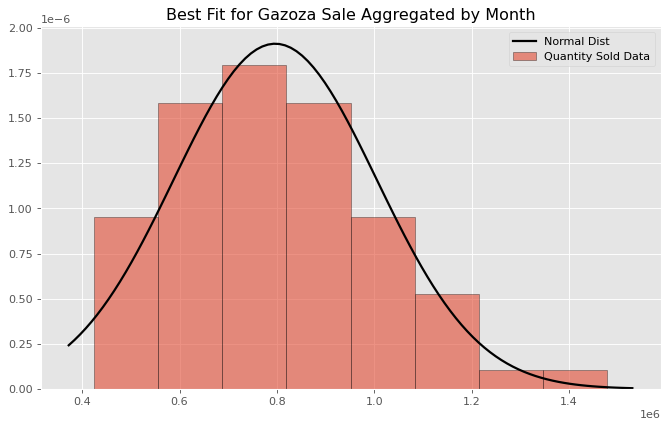

In [46]:
# Plot the Histogram
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(qty, bins = 8, edgecolor='black', alpha = 0.6, density = True, label = "Quantity Sold Data") 

# Plot the PDF.
xmin_qty, xmax_qty = plt.xlim()
x_qty = np.linspace(xmin_qty, xmax_qty, 100)
p_qty = norm.pdf(x_qty, np.mean(qty), np.std(qty))
plt.plot(x_qty, p_qty, 'k', linewidth=2, label = "Normal Dist")
title_qty = "Best Fit for Gazoza Sale Aggregated by Month"
plt.legend(loc='best')
plt.title(title_qty)

plt.show()

In [47]:
orderQuan(np.mean(qty), np.std(qty), 0.3, 0.4)

array([758986.05493514])